In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset,random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import albumentations
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [ ]:
Dir="/content/drive/MyDrive/dataset/image_leaf/train/"
Dir2="/content/drive/MyDrive/dataset/image_leaf/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device=torch.device( "cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
img_folder=["jpg","JPG","PNG","png"]
df=pd.DataFrame()
count=0
for folder in os.listdir(Dir):
  Path=os.path.join(Dir,folder)
  for img in os.listdir(Path):
    full_path=os.path.join(Path,img)
    if full_path.split(".")[-1] not in img_folder:
      continue
    df.loc[count,"Image"]=full_path
    df.loc[count,"label"]=folder
    count+=1

In [ ]:
df.head()

,Image,label
0,/content/drive/MyDrive/dataset/image_leaf/trai...,diseased cotton plant
1,/content/drive/MyDrive/dataset/image_leaf/trai...,diseased cotton plant
2,/content/drive/MyDrive/dataset/image_leaf/trai...,diseased cotton plant
3,/content/drive/MyDrive/dataset/image_leaf/trai...,diseased cotton plant
4,/content/drive/MyDrive/dataset/image_leaf/trai...,diseased cotton plant


In [ ]:
df["label"].value_counts()

diseased cotton plant    820
fresh cotton leaf        437
fresh cotton plant       431
diseased cotton leaf     311
Name: label, dtype: int64

In [ ]:
mapping={idx:value for value,idx in enumerate(np.unique(df["label"]))}
df["label"]=df["label"].map(mapping).astype(float)

In [ ]:
mapping

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [ ]:
len(mapping)

4

In [ ]:
df.head()

,Image,label
0,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0
1,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0
2,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0
3,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0
4,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count_Label')

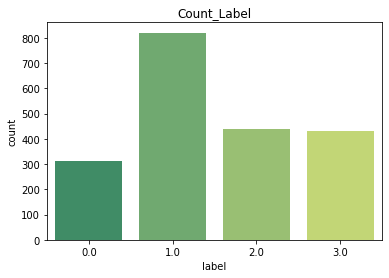

In [ ]:
sns.countplot(df["label"],palette="summer")
plt.title("Count_Label")

In [ ]:
df.to_csv(Dir2+"All_images.csv")

In [ ]:
df=pd.read_csv(Dir2+"All_images.csv")

In [ ]:
df.head()

,Unnamed: 0,Image,label
0,0,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0
1,1,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0
2,2,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0
3,3,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0
4,4,/content/drive/MyDrive/dataset/image_leaf/trai...,1.0


In [ ]:
df["label"].value_counts()

1.0    820
2.0    437
3.0    431
0.0    311
Name: label, dtype: int64

In [ ]:
X=df["Image"].values
y=df["label"].values

In [ ]:
X.shape,y.shape

((1999,), (1999,))

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self,images,label,tfms=None):
    self.X=images
    self.Y=label
    if tfms==None:
      self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
            ])
    else:
      self.aug=albumentations.Compose([albumentations.Resize(224,224,always_apply=True),
                albumentations.HorizontalFlip(p=0.5),
                albumentations.ShiftScaleRotate(shift_limit=0.3,
                                                scale_limit=0.3,rotate_limit=15,p=0.5)])
      

  def __len__(self):
    return len(self.X)


  def __getitem__(self,index):
    image=Image.open(self.X[index])
    image=image.convert("RGB")
    image=self.aug(image=np.array(image))["image"]
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    label=self.Y[index]
    return (torch.tensor(image,dtype=torch.float),torch.tensor(label,dtype=torch.long))

In [ ]:
train_dataset=ImageDataset(X_train,Y_train,1)

In [ ]:
len(train_dataset)

1399

In [ ]:
valid_dataset=ImageDataset(X_test,Y_test)

In [ ]:
len(valid_dataset)

600

In [ ]:
trainLoader=DataLoader(train_dataset,shuffle=True,batch_size=32)

In [ ]:
validLoader=DataLoader(valid_dataset,shuffle=True,batch_size=32)

In [ ]:
next(iter(trainLoader))

[tensor([[[[101., 100., 102.,  ..., 120., 123., 119.],
           [ 98.,  96., 100.,  ..., 116., 116., 113.],
           [ 99.,  99., 100.,  ..., 117., 115., 112.],
           ...,
           [ 95.,  97., 107.,  ..., 112., 109., 110.],
           [ 89., 104., 117.,  ..., 112., 108., 107.],
           [ 78., 100., 116.,  ..., 110., 109., 107.]],
 
          [[132., 131., 133.,  ..., 154., 158., 154.],
           [129., 127., 131.,  ..., 150., 150., 146.],
           [130., 130., 131.,  ..., 151., 148., 146.],
           ...,
           [ 85.,  85.,  93.,  ..., 145., 142., 140.],
           [ 78.,  92., 103.,  ..., 145., 141., 137.],
           [ 67.,  88., 103.,  ..., 143., 142., 139.]],
 
          [[ 73.,  72.,  74.,  ..., 101., 105., 100.],
           [ 72.,  69.,  73.,  ...,  98., 100.,  97.],
           [ 73.,  73.,  75.,  ..., 100.,  99.,  98.],
           ...,
           [ 73.,  70.,  76.,  ...,  74.,  71.,  70.],
           [ 65.,  76.,  85.,  ...,  74.,  70.,  67.],
           

In [ ]:
for x,y in trainLoader:
  print(x.shape)
  break

torch.Size([32, 3, 224, 224])


In [ ]:
class Module(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(3,16,5)
    self.conv2=nn.Conv2d(16,32,5)
    self.conv3=nn.Conv2d(32,64,3)
    self.conv4=nn.Conv2d(64,128,5)
    self.pool=nn.MaxPool2d(2,2)
    self.dropout=nn.Dropout(p=0.3)
    self.linear1=nn.Linear(128,256)
    self.linear2=nn.Linear(256,4)
    # self.softmax=nn.Softmax(dim=1)
    # self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    x=self.pool(F.relu(self.conv4(x)))
    bs,_,_,_=x.shape
    x=F.adaptive_avg_pool2d(x,1).reshape(bs,-1)
    x=self.dropout(x)
    x=F.relu(self.linear1(x))
    x=self.linear2(x)
    return x

In [ ]:
model=Module().to(device)
model

Module(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

In [ ]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [ ]:
# def fit(model,train_loader):
#   model.train()
#   train_running_loss=0
#   train_running_correct=0
#   epochs=100
#   for epoch in range(epochs):
#     running_loss = 0.00
#     for i,data in tqdm(enumerate(train_loader)):
#       data,target=data[0],data[1]
#       output=model(data)
#       loss=criterion(output,target)
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       running_loss += loss.item()

#     running_loss /= len(train_loader)

#     training_accuracy = accuracy(output, target)

#     print('='*10,'iteration: {0}'.format(epoch+1),'='*10,)
#     print('\n Loss: {0} \n Training accuracy:{1}% '.format(running_loss, training_accuracy))

#     return running_loss,training_accuracy
      

In [ ]:
def fit(model,train_loader):
  model.train()
  train_running_loss=0
  train_running_correct=0
  for i,data in enumerate(train_loader):
    data,target=data[0].to(device),data[1].to(device)
    optimizer.zero_grad()
    outputs=model(data)
    loss=criterion(outputs,target)
    train_running_loss+=loss.item()
    _,preds=torch.max(outputs.data,1)
    train_running_correct+=(preds == target).sum().item()
    loss.backward()
    optimizer.step()

  train_loss=train_running_loss / len(train_loader.dataset)
  train_accuracy=100*train_running_correct / len(train_loader.dataset)

  print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")

  return train_loss,train_accuracy

In [ ]:
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
      for i, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        outputs=model(data)
        loss = criterion(outputs, target)
        val_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        val_running_correct += (preds == target).sum().item()
        
      val_loss = val_running_loss/len(test_dataloader.dataset)
      val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
      print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')

        
        
      return val_loss, val_accuracy

In [ ]:
import time

In [ ]:
train_loss,train_accuracy=[],[]
val_loss,val_accuracy=[],[]
start=time.time()
for epoch in range(50):
  print(f"Epoch {epoch+1}")
  train_epoch_loss,train_epoch_accuracy=fit(model,trainLoader)
  test_epoch_loss,test_epoch_accuracy=validate(model,validLoader)
  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)
  val_loss.append(test_epoch_loss)
  val_accuracy.append(test_epoch_accuracy)
  torch.save(model.state_dict(),Dir2+"images_data.pt")

end = time.time()
print(f"{(end-start)/60:.3f} minutes")

Epoch 1
Train Loss: 0.0429, Train Acc: 42.39
Validating
Val Loss: 0.0363, Val Acc: 47.00
Epoch 2
Train Loss: 0.0360, Train Acc: 48.75
Validating
Val Loss: 0.0354, Val Acc: 49.17
Epoch 3
Train Loss: 0.0322, Train Acc: 52.97
Validating
Val Loss: 0.0292, Val Acc: 62.67
Epoch 4
Train Loss: 0.0321, Train Acc: 56.54
Validating
Val Loss: 0.0320, Val Acc: 60.17
Epoch 5
Train Loss: 0.0287, Train Acc: 60.33
Validating
Val Loss: 0.0327, Val Acc: 50.17
Epoch 6
Train Loss: 0.0298, Train Acc: 59.76
Validating
Val Loss: 0.0249, Val Acc: 68.00
Epoch 7
Train Loss: 0.0242, Train Acc: 69.26
Validating
Val Loss: 0.0203, Val Acc: 75.83
Epoch 8
Train Loss: 0.0214, Train Acc: 72.34
Validating
Val Loss: 0.0199, Val Acc: 74.00
Epoch 9
Train Loss: 0.0239, Train Acc: 68.33
Validating
Val Loss: 0.0197, Val Acc: 72.50
Epoch 10
Train Loss: 0.0191, Train Acc: 77.06
Validating
Val Loss: 0.0162, Val Acc: 80.17
Epoch 11
Train Loss: 0.0169, Train Acc: 79.99
Validating
Val Loss: 0.0165, Val Acc: 79.67
Epoch 12
Train Loss

In [ ]:
mo

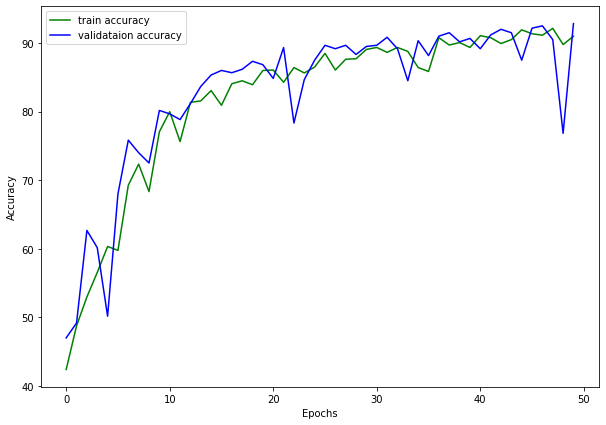

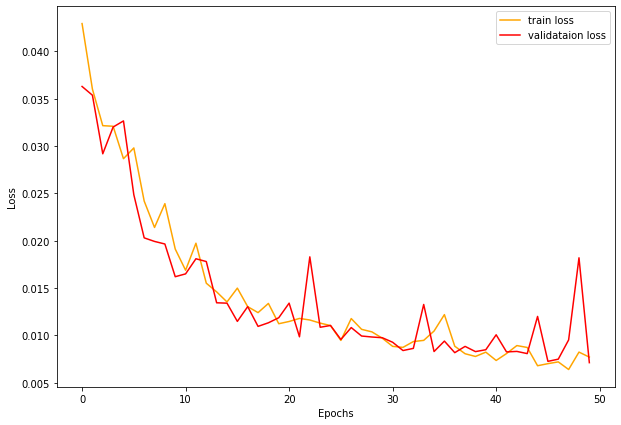

TRAINING COMPLETE


In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(Dir2+'accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(Dir2+'loss.png')
plt.show()
    
# serialize the model to disk
# print('Saving model...')
# torch.save(model.state_dict(), args['model'])
 
print('TRAINING COMPLETE')

In [ ]:
model.eval()

Module(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
model2=torch.load(Dir2+"images_data.pt")
model2.eval()

AttributeError: ignored

In [ ]:
import torchvision.transforms as transforms

In [ ]:
from torch.autograd import Variable

In [ ]:
img_path="/content/drive/MyDrive/dataset/image_leaf/train/diseased cotton leaf/dis_leaf (1)_iaip.jpg"

In [ ]:
imsize = 224
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])



def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU


image = image_loader(img_path)
model(image)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


tensor([[-0.4496, -2.7188,  3.7776, -2.0119]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [ ]:
model_ft=torch.load(Dir2+"images_data.pt")


In [ ]:
model_ft.

OrderedDict([('conv1.weight',
              tensor([[[[ 7.0260e-02,  8.9896e-02,  9.7107e-02, -7.1513e-02,  2.7322e-02],
                        [-1.7621e-02,  9.7328e-02,  9.5822e-02, -3.3066e-02,  1.1488e-01],
                        [ 9.0156e-02,  9.6282e-02, -3.4574e-02, -9.7559e-02,  1.1560e-01],
                        [ 6.5116e-02, -9.8436e-02,  1.0520e-01, -9.9401e-02,  5.1926e-02],
                        [-4.8454e-02, -6.2831e-02,  8.9748e-02, -2.5183e-02,  8.3566e-02]],
              
                       [[-1.7741e-02, -4.5197e-02,  8.5473e-02, -5.7047e-02, -2.8778e-02],
                        [ 5.4431e-02,  7.9107e-02, -3.3771e-02, -1.1894e-01, -9.4713e-02],
                        [-9.8544e-02, -9.5127e-02,  6.2488e-02,  2.9828e-02, -7.4167e-02],
                        [-1.2564e-01, -8.1213e-02, -1.2175e-01, -2.8075e-02,  6.7015e-02],
                        [ 1.0440e-01,  9.5835e-02,  4.1647e-02, -7.0193e-02, -3.1430e-02]],
              
                       [[-8.

In [ ]:
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = image.unsqueeze(0) 
    return image.cuda()
image = image_loader(img_path) 
with torch.no_grad():
    logits = model.forward(image)
ps = torch.exp(logits)
_, predTest = torch.max(ps,1)
print(ps) ## same value in all cases
imagen_mostrar = images[ii].to('cpu') 

tensor([[0.6495, 0.8998, 1.5328, 1.0076]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


NameError: ignored

In [ ]:
from torchvision import datasets

In [ ]:
model.eval()

AttributeError: ignored

In [ ]:
data_dir = ("/content/drive/MyDrive/dataset/image_leaf/predict_img/")
dara_dir=Dir
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

TypeError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
import torchvision.transforms.functional as TF

In [ ]:
new_input = Image.open(img_path)
model.eval()
outputs = model(torch.cat([new_input ], 1))

TypeError: ignored